In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

weather_data = pd.read_csv('london_weather.csv')
weather_data = weather_data[['date', 'mean_temp']]
weather_data = weather_data.set_index('date', drop = True)
weather_data.index = pd.to_datetime(weather_data.index,format="%Y%m%d")
weather_data = weather_data.fillna(method='ffill')
weather_data.head()


,mean_temp
date,
1979-01-01,-4.1
1979-01-02,-2.6
1979-01-03,-2.8
1979-01-04,-2.6
1979-01-05,-0.8


Text(0, 0.5, 'Temp')

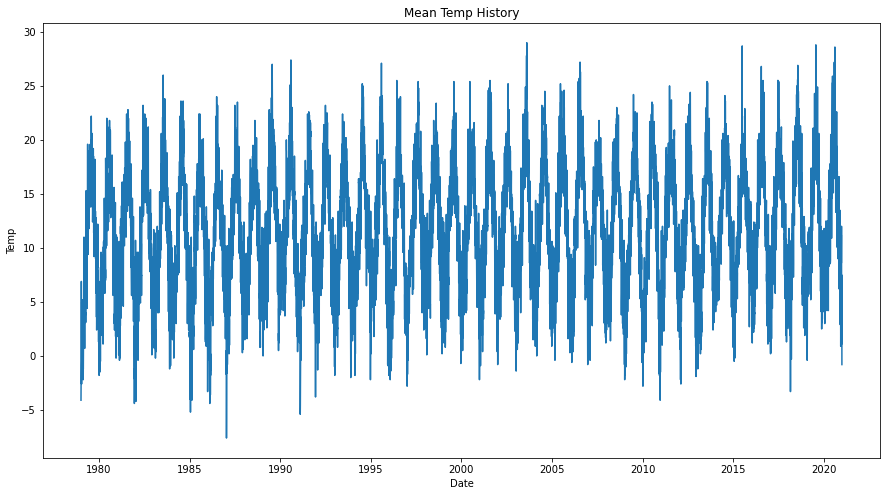

In [2]:
plt.figure(figsize=(15, 8))
plt.title('Mean Temp History')
plt.plot(weather_data['mean_temp'])
plt.xlabel('Date')
plt.ylabel('Temp')

In [3]:
#close_prices = stock_data['Price']
values = weather_data.values
training_data_len = math.ceil(len(values)*0.8 )

#scaler = MinMaxScaler(feature_range=(0,1))
#scaled_data = scaler.fit_transform(values.reshape(-1,1))

#train_data = scaled_data[0: training_data_len, :]
values = values.reshape(-1,1)
train_data = values[0: training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [4]:
test_data = values[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [5]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 10, epochs=10)

Epoch 1/10
1222/1222 [==============================] - 36s 27ms/step - loss: 5.4002
Epoch 2/10
1222/1222 [==============================] - 31s 25ms/step - loss: 3.7857
Epoch 3/10
1222/1222 [==============================] - 31s 25ms/step - loss: 3.7913
Epoch 4/10
1222/1222 [==============================] - 32s 26ms/step - loss: 3.6951
Epoch 5/10
1222/1222 [==============================] - 33s 27ms/step - loss: 3.6538
Epoch 6/10
1222/1222 [==============================] - 33s 27ms/step - loss: 3.6151
Epoch 7/10
1222/1222 [==============================] - 34s 27ms/step - loss: 3.5899
Epoch 8/10
1222/1222 [==============================] - 34s 28ms/step - loss: 3.5799
Epoch 9/10
1222/1222 [==============================] - 34s 28ms/step - loss: 3.5786
Epoch 10/10
1222/1222 [==============================] - 34s 28ms/step - loss: 3.5630


In [7]:
predictions = model.predict(x_test)
#predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

96/96 [==============================] - 2s 15ms/step


0.03720518952038872

<ipython-input-8-edb5666fa765>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


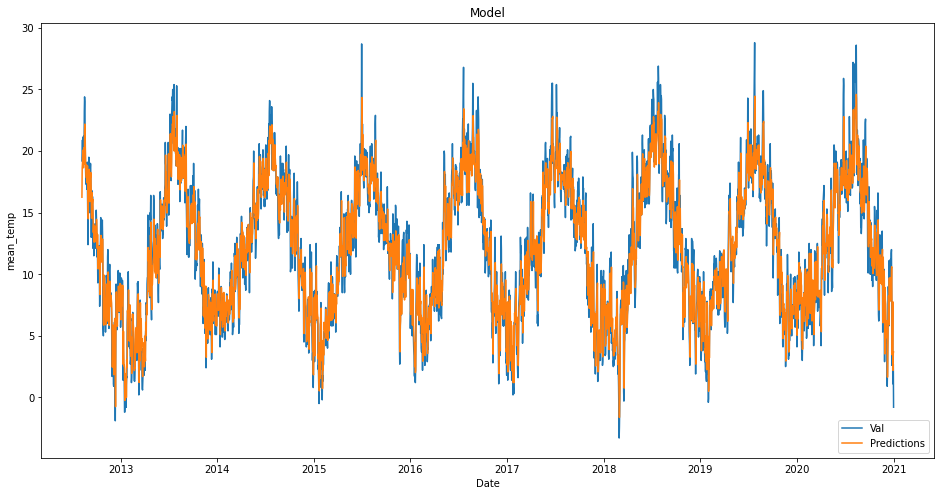

In [8]:
data = weather_data.filter(['mean_temp'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('mean_temp')
#plt.plot(train)
plt.plot(validation[['mean_temp', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [9]:
# generate the multi-step forecasts
n_future = 365 
y_future = []

x_pred = x_test[-1:, :, :]  # last observed input sequence
y_pred = y_test[-1]         # last observed target value

for i in range(n_future):

    # feed the last forecast back to the model as an input
    x_pred = np.append(x_pred[:, 1:, :], y_pred.reshape(1, 1, 1), axis=1)

    # generate the next forecast
    y_pred = model.predict(x_pred)

    # save the forecast
    y_future.append(y_pred.flatten()[0])

# transform the forecasts back to the original scale
y_future = np.array(y_future).reshape(-1, 1)
#y_future = scaler.inverse_transform(y_future)

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step


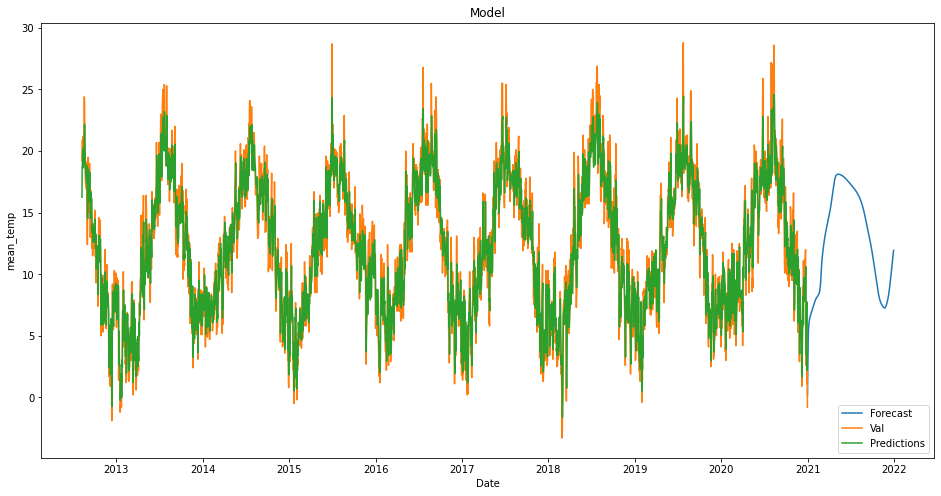

In [15]:
df_future = pd.DataFrame(columns=['Date', 'Forecast'])
df_future['Date'] = pd.date_range(start='2020-12-31', periods=n_future)
df_future['Forecast'] = y_future.flatten()
df_future = df_future.set_index('Date')

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('mean_temp')
plt.plot(df_future)
plt.plot(validation[['mean_temp', 'Predictions']])
plt.legend(['Forecast','Val', 'Predictions'], loc='lower right')
plt.show()

In [11]:
df_future

,Forecast
Date,
2020-12-31,0.200009
2021-01-01,1.785464
2021-01-02,3.351461
2021-01-03,4.608507
2021-01-04,5.366273
...,...
2021-12-26,11.246427
2021-12-27,11.425521
2021-12-28,11.600007
